# Chapter06 학습 관련 기술들

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

### 6.1 매개변수 갱신

- 확률적 경사 하강법 (SGD) :

 $W ← W - \eta \frac{\partial L}{\partial W}$

 - $W$ : 갱신할 매개변수

 - $\eta$ : 학습률

 - $\frac{\partial L}{\partial W}$ : W에 대한 손실함수의 기울기

 기울어진 방향으로 일정 거리만 가겠다는 단순한 방법

In [2]:
# SGD 구현
class SGD(object):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):   # 갱신
        for key in params.keys():
            params[key] -= self.lr * grads[key]

    # SGD 과정에서 반복해서 update()메서드를 부른다

SGD 클래스를 사용하면 신경망의 매개변수 진행을 다음과 같이 수행할 수 있다.

    network = TwoLayerNet(...)
    optimizer = SGD()

    for i in range(10000):
        ...
        x_batch, t_batch = get_mini_batch(...)
        grads = network.gradient(x_batch, t_batch)
        params = network.params
        optimizer.update(params, grads)
        ...
    
이렇게 optimizer에 매개변수와 기울기만 전달해주면 된다.

---

SGD의 단점 : 비등방성 함수에서 탐색 경로가 비효율적이다. ( 지그재그로 탐색 )

- **모멘텀** : 

 $v ← \alpha v - \eta \frac{\partial L}{\partial W}$

 $W ← W + v$

즉, Gradient의 진행이 [그림 6-3] 에서와 같았다면 위 아래로 변하는 b축 gradient factor들은 더하기 빼기 해주게 되면서 서서히 속도가 0으로 가까워 질 것이고, 오른쪽으로 계속 진행되는 gradient의 W축 방향 factor들은 계속 더해주게 되어 관성이 작용하는 것 처럼 속도가 점점 붙을 것이다.

In [3]:
# 모멘텀 구현

class Momentum(object):
    def __init__(self, lr=0.01, momentum=0.9):  # 대체로 momentum=0.9로 설정
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):    
        if self.v is None:      # v: 0으로 초기화 
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]
        
# v는 이전 갱신에 영향을 받게 되며, 이전 갱신값이 크다면, 이번에 그만큼 가속도를 받게 된다

학습률 감소 : 학습을 진행하면서 학습률을 점차 줄여가는 방법

- **AdaGrad** : '각각의' 매개변수에 '맞춤형' 값을 만들어줌

 $h ← h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W}$  $\space\space$(⊙ : 원소별 곱셈)

 $W ← W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$

 크게 갱신된 원소는 큰 폭으로 학습률이 낮아진다. (학습률 감소가 원소마다 다르게 적용됨)

 AdaGrad는 과거의 기울기를 제곱하여 계속 더해간다. (누적합) ---> 실제로 무한히 학습하면 갱신량이 0이 되어 갱신 X

 - --> **RMSProp** 기법 : 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영 (지수이동평균)

In [4]:
# Adagrad 구현

class AdaGrad(object):
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


- **RMSProp**:

 $h_i \leftarrow ph + (1-p)\frac{\partial{L}}{\partial{W}}\odot\frac{\partial{L}}{\partial{W}}$

 $p$ 값이 작을수록 최신 기울기를 많이 반영됨

In [ ]:
# RMSProp 구현
class RMSProp(object):
    def __init__(self, lr = 0.01, p = 0.9):
        self.lr = lr
        self.p = p # AdaGrad에서 추가된 변수
        self.h = None

    def update(self, params, grads):
        if self.h is None: # 처음 갱신할 때
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] = self.p * self.h[key] + (1 - self.p) * (grads[key] * grads[key]) # 식 반영
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

- **Adam** : 모멘텀과 AdaGrad를 융합한 방법

In [5]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1  # 모멘텀 매개변수
        self.beta2 = beta2  # AdaGrad 매개변수
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1

        # learning rate를 beta를 통해 조정
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])      # Momentum
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])   # AdaGrad + RMSProp
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # AdaGrad + RMSProp
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [6]:
path = "/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master"
os.chdir(path)
sys.path.append(os.chdir)

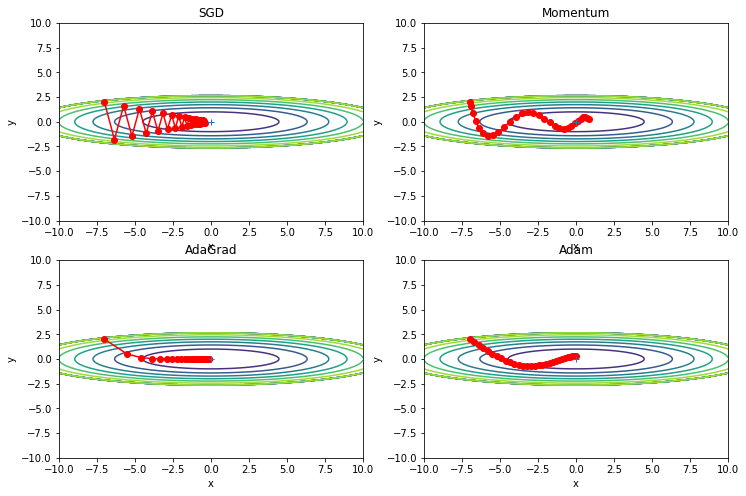

In [7]:
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = {}
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

plt.figure(figsize=(12,8))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.348460328961937
Momentum:2.4203982166177465
AdaGrad:2.183747379636703
Adam:2.2168603011736745
===========iteration:100===========
SGD:1.296033324731626
Momentum:0.4398393308595176
AdaGrad:0.19024934503516244
Adam:0.3968845673615474
===========iteration:200===========
SGD:0.6608568041867324
Momentum:0.2630478343601355
AdaGrad:0.10955566603581493
Adam:0.191830672157015
===========iteration:300===========
SGD:0.46831418975478895
Momentum:0.24971025924764656
AdaGrad:0.07215209381276243
Adam:0.14391236767354182
===========iteration:400===========
SGD:0.3471648006035198
Momentum:0.17907390816608237
AdaGrad:0.06432186623105605
Adam:0.13574307902661245
===========iteration:500===========
SGD:0.2616843198452717
Momentum:0.13629745045212313
AdaGrad:0.05453897405036284
Adam:0.06888363207192023
===========iteration:600===========
SGD:0.3112048252511672
Momentum:0.11822503139508156
AdaGrad:0.06673142898223645
Adam:0.07009441899484495
===========iteration:700=

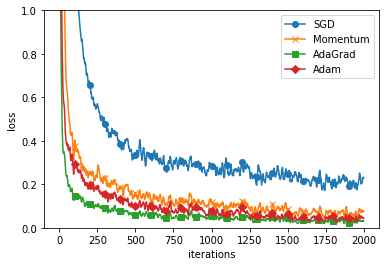

In [8]:
# MNIST 데이터셋으로 각 optimizer 성능 비교
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 6.2 가중치의 초깃값

- 가중치 감소 : 가중치 매개변수의 값이 작아지도록 학습하는 방법 --> 오버피팅 억제!

가중치의 초깃값을 0으로 (균일한 값으로) 설정하면 안좋은 이유:

오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문

--> 초깃값을 무작위로 설정해야 함

In [9]:
# 가중치 초깃값에 따른 은닉층의 활성화값 분포 관찰

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100          # 각 은닉층의 노드 수
hidden_layer_size = 5   # 은닉층이 5개
activations = {}        # 이곳에 활성화값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1   # 가중치의 표준편차가 1인 정규분포
    a = np.dot(x, w)    # (1000, 100)
    z = sigmoid(a)
    activations[i] = z

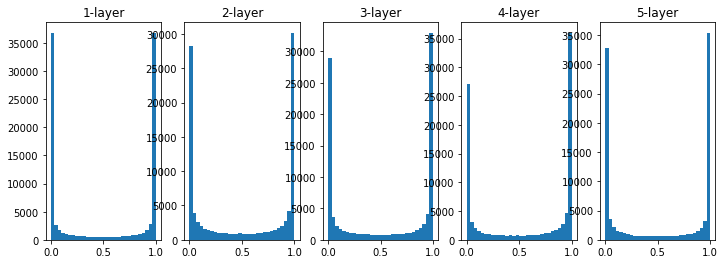

In [10]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

각 층의 활성화값들이 0과 1에 치우쳐 있다.

--> 미분이 0에 다가가기 때문에 역전파의 기울기 값이 입력층에 다가갈수록 점점 작아지다가 사라진다. ( **기울기 소실** )

In [11]:
# 가중치 표준편차 바꿔서 실험

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100         
hidden_layer_size = 5  
activations = {}       

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01   # 가중치의 표준편차가 0.01인 정규분포
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

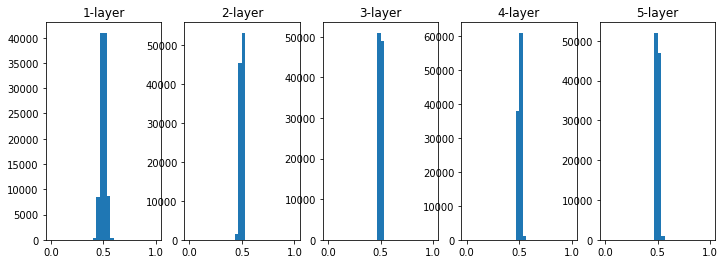

In [12]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0.5 부근에 집중됨 --> 기울기 소실은 해결했으나 / 활성화값이 치우쳐져서 여러 뉴런을 둔 의미가 없어지게 된다.

- 각 층의 활성화값은 고르게 분포되어야 한다. ( 신경망 학습을 효율적으로 이뤄지게 하기 위해 )

---

- Xavier 초깃값 :

 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포 사용

In [13]:
# Xavier 초깃값 사용

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100          # 앞층의 노드 수
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

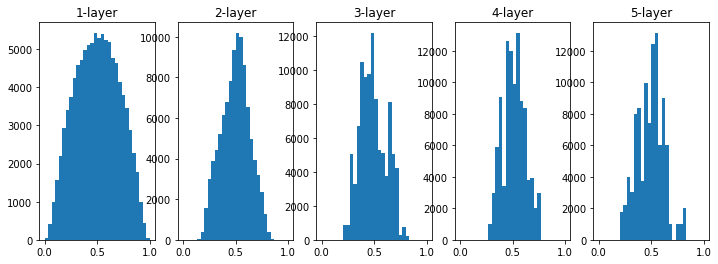

In [14]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨! --> 학습 효율적일 것으로 기대됨

In [15]:
# 활성화 함수로 tanh 사용

def tanh(x):
    return np.tanh(x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

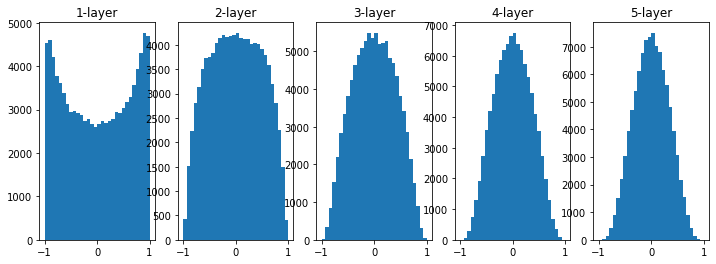

In [16]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

- 활성화함수로 tanh 함수를 쓰니까 말끔한 종 모양으로 분포됨!

sigmoid는 (0, 0.5)에서 대칭이고, tanh는 (0, 0)에서 대칭이다.

활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있다.

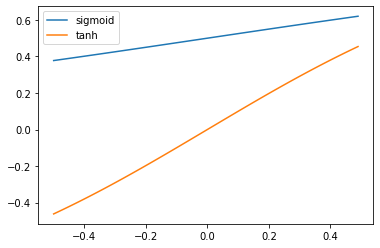

In [17]:
x = np.arange(-0.5, 0.5, 0.01)
y1 = sigmoid(x)
y2 = tanh(x)
plt.plot(x,y1)
plt.plot(x,y2)
plt.legend(['sigmoid','tanh'])
plt.show()

--> sigmoid와 tanh함수는 좌우대칭이라 중앙부근에서 선형이기 때문에 Xavier 초깃값이 적당하다

반면 ReLU를 사용할 때는 **' He 초깃값 '**을 이용한다

- He 초깃값 :

 앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$ 인 분포 사용

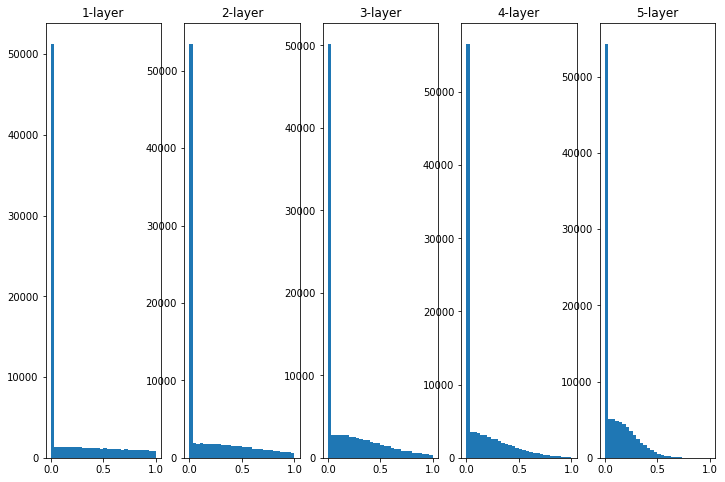

In [18]:
# 활성화 함수로 ReLU 사용 (Xavier 초깃값)

def ReLU(x):
    return np.maximum(x, 0)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = ReLU(a)
    activations[i] = z

# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

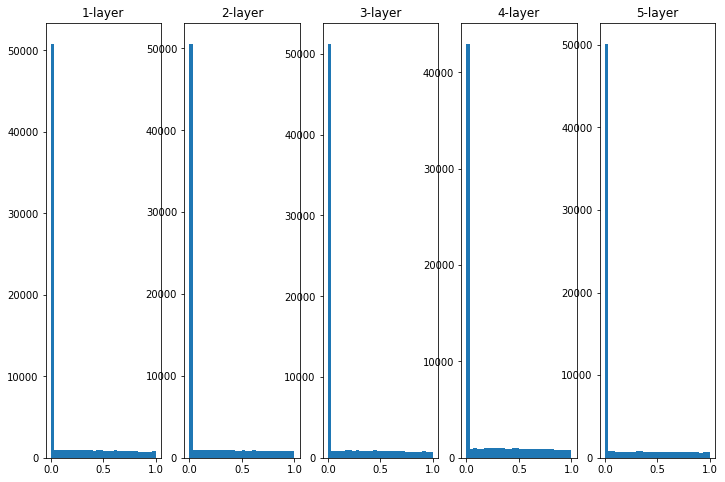

In [19]:
# 활성화 함수로 ReLU 사용 (He 초깃값)

def ReLU(x):
    return np.maximum(x, 0)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * np.sqrt(2/node_num)   # He 초깃값 사용
    a = np.dot(x, w)
    z = ReLU(a)
    activations[i] = z

# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

ReLU를 사용한 경우

Xavier : 층이 깊어지면서 치우침이 조금씩 커짐

He : 층이 깊어져도 분포가 균일하게 유지됨

===========iteration:0===========
std=0.01:2.302487357368296
Xavier:2.299323413591702
He:2.3814069283399832
===========iteration:100===========
std=0.01:2.3023626485235176
Xavier:2.244775152832123
He:1.323527760558011
===========iteration:200===========
std=0.01:2.300864870372811
Xavier:2.1450657664931807
He:0.7207369146833597
===========iteration:300===========
std=0.01:2.300942388055895
Xavier:1.7386829746377672
He:0.37874406280606354
===========iteration:400===========
std=0.01:2.3035689155084462
Xavier:1.1453325557351342
He:0.3462476029590019
===========iteration:500===========
std=0.01:2.306779101834225
Xavier:0.9418907588334211
He:0.5298540264249189
===========iteration:600===========
std=0.01:2.2992488079669324
Xavier:0.7823088413836482
He:0.45227196500170586
===========iteration:700===========
std=0.01:2.3015753551642772
Xavier:0.6460417205030113
He:0.40905892323485454
===========iteration:800===========
std=0.01:2.3030352619728003
Xavier:0.5788362410058221
He:0.357899254831006

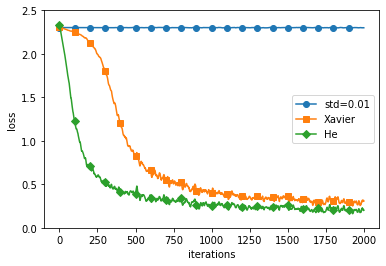

In [20]:
# MNIST 데이터셋으로 가중치 초깃값 비교하기 (활성화함수로 ReLU함수 적용)

from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 6.3 배치 정규화

활성화값이 적당히 분포되도록 조정하는 것

- 학습을 빨리 진행할 수 있다.

- 초깃값에 크게 의존하지 않는다.

- 오버피팅을 억제한다.

============== 1/16 ==============
epoch:0 | 0.117 - 0.099


/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.083
epoch:2 | 0.097 - 0.075
epoch:3 | 0.097 - 0.095
epoch:4 | 0.097 - 0.097
epoch:5 | 0.097 - 0.121
epoch:6 | 0.097 - 0.139
epoch:7 | 0.097 - 0.164
epoch:8 | 0.097 - 0.188
epoch:9 | 0.097 - 0.208
epoch:10 | 0.097 - 0.224
epoch:11 | 0.097 - 0.243
epoch:12 | 0.097 - 0.249
epoch:13 | 0.097 - 0.26
epoch:14 | 0.097 - 0.274
epoch:15 | 0.097 - 0.294
epoch:16 | 0.097 - 0.306
epoch:17 | 0.097 - 0.327
epoch:18 | 0.097 - 0.331


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.342
============== 2/16 ==============
epoch:0 | 0.094 - 0.104


/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.098
epoch:2 | 0.097 - 0.12
epoch:3 | 0.097 - 0.169
epoch:4 | 0.097 - 0.196
epoch:5 | 0.097 - 0.224
epoch:6 | 0.097 - 0.266
epoch:7 | 0.097 - 0.289
epoch:8 | 0.097 - 0.308
epoch:9 | 0.097 - 0.345
epoch:10 | 0.097 - 0.369
epoch:11 | 0.097 - 0.398
epoch:12 | 0.097 - 0.427
epoch:13 | 0.097 - 0.437
epoch:14 | 0.097 - 0.458
epoch:15 | 0.097 - 0.468
epoch:16 | 0.097 - 0.473
epoch:17 | 0.097 - 0.494
epoch:18 | 0.097 - 0.518


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.537
============== 3/16 ==============
epoch:0 | 0.126 - 0.107
epoch:1 | 0.359 - 0.129
epoch:2 | 0.528 - 0.146
epoch:3 | 0.604 - 0.18
epoch:4 | 0.703 - 0.227
epoch:5 | 0.771 - 0.274
epoch:6 | 0.824 - 0.315
epoch:7 | 0.855 - 0.366
epoch:8 | 0.88 - 0.399
epoch:9 | 0.914 - 0.439
epoch:10 | 0.928 - 0.474
epoch:11 | 0.935 - 0.497
epoch:12 | 0.95 - 0.514
epoch:13 | 0.957 - 0.543
epoch:14 | 0.961 - 0.572
epoch:15 | 0.964 - 0.593
epoch:16 | 0.969 - 0.623
epoch:17 | 0.973 - 0.651
epoch:18 | 0.976 - 0.66


No handles with labels found to put in legend.


epoch:19 | 0.981 - 0.676
============== 4/16 ==============
epoch:0 | 0.1 - 0.104
epoch:1 | 0.274 - 0.148
epoch:2 | 0.42 - 0.224
epoch:3 | 0.504 - 0.292
epoch:4 | 0.575 - 0.37
epoch:5 | 0.619 - 0.412
epoch:6 | 0.65 - 0.466
epoch:7 | 0.68 - 0.522
epoch:8 | 0.698 - 0.567
epoch:9 | 0.72 - 0.586
epoch:10 | 0.734 - 0.613
epoch:11 | 0.76 - 0.649
epoch:12 | 0.783 - 0.674
epoch:13 | 0.792 - 0.707
epoch:14 | 0.803 - 0.726
epoch:15 | 0.823 - 0.746
epoch:16 | 0.822 - 0.757
epoch:17 | 0.841 - 0.777
epoch:18 | 0.837 - 0.793


No handles with labels found to put in legend.


epoch:19 | 0.859 - 0.797
============== 5/16 ==============
epoch:0 | 0.113 - 0.103
epoch:1 | 0.117 - 0.127
epoch:2 | 0.114 - 0.276
epoch:3 | 0.119 - 0.427
epoch:4 | 0.123 - 0.538
epoch:5 | 0.135 - 0.599
epoch:6 | 0.157 - 0.664
epoch:7 | 0.169 - 0.705
epoch:8 | 0.193 - 0.742
epoch:9 | 0.226 - 0.754
epoch:10 | 0.241 - 0.768
epoch:11 | 0.252 - 0.785
epoch:12 | 0.274 - 0.803
epoch:13 | 0.289 - 0.819
epoch:14 | 0.309 - 0.833
epoch:15 | 0.322 - 0.845
epoch:16 | 0.336 - 0.853
epoch:17 | 0.351 - 0.864
epoch:18 | 0.361 - 0.876


No handles with labels found to put in legend.


epoch:19 | 0.366 - 0.882
============== 6/16 ==============
epoch:0 | 0.118 - 0.097
epoch:1 | 0.117 - 0.234
epoch:2 | 0.171 - 0.43
epoch:3 | 0.122 - 0.561
epoch:4 | 0.124 - 0.648
epoch:5 | 0.117 - 0.711
epoch:6 | 0.116 - 0.751
epoch:7 | 0.116 - 0.777
epoch:8 | 0.116 - 0.804
epoch:9 | 0.116 - 0.838
epoch:10 | 0.116 - 0.861
epoch:11 | 0.116 - 0.879
epoch:12 | 0.116 - 0.894
epoch:13 | 0.116 - 0.902
epoch:14 | 0.116 - 0.91
epoch:15 | 0.116 - 0.924
epoch:16 | 0.116 - 0.933
epoch:17 | 0.116 - 0.941
epoch:18 | 0.116 - 0.946


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.954
============== 7/16 ==============
epoch:0 | 0.105 - 0.097
epoch:1 | 0.116 - 0.359
epoch:2 | 0.116 - 0.639
epoch:3 | 0.117 - 0.702
epoch:4 | 0.117 - 0.747
epoch:5 | 0.117 - 0.783
epoch:6 | 0.117 - 0.828
epoch:7 | 0.116 - 0.848
epoch:8 | 0.116 - 0.869
epoch:9 | 0.116 - 0.89
epoch:10 | 0.116 - 0.922
epoch:11 | 0.117 - 0.943
epoch:12 | 0.117 - 0.957
epoch:13 | 0.116 - 0.963
epoch:14 | 0.116 - 0.971
epoch:15 | 0.117 - 0.974
epoch:16 | 0.117 - 0.978
epoch:17 | 0.117 - 0.983
epoch:18 | 0.117 - 0.986


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.987
============== 8/16 ==============
epoch:0 | 0.117 - 0.102
epoch:1 | 0.117 - 0.428
epoch:2 | 0.116 - 0.699
epoch:3 | 0.116 - 0.806
epoch:4 | 0.116 - 0.849
epoch:5 | 0.116 - 0.896
epoch:6 | 0.116 - 0.931
epoch:7 | 0.116 - 0.952
epoch:8 | 0.116 - 0.963
epoch:9 | 0.116 - 0.975
epoch:10 | 0.116 - 0.982
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.992
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.997
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 9/16 ==============
epoch:0 | 0.094 - 0.084
epoch:1 | 0.116 - 0.35
epoch:2 | 0.116 - 0.741
epoch:3 | 0.116 - 0.846
epoch:4 | 0.116 - 0.911
epoch:5 | 0.116 - 0.941
epoch:6 | 0.116 - 0.966
epoch:7 | 0.116 - 0.976
epoch:8 | 0.117 - 0.978
epoch:9 | 0.117 - 0.987
epoch:10 | 0.116 - 0.992
epoch:11 | 0.117 - 0.995
epoch:12 | 0.117 - 0.998
epoch:13 | 0.117 - 0.998
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 10/16 ==============
epoch:0 | 0.093 - 0.093
epoch:1 | 0.116 - 0.433
epoch:2 | 0.116 - 0.778
epoch:3 | 0.116 - 0.846
epoch:4 | 0.116 - 0.809
epoch:5 | 0.116 - 0.88
epoch:6 | 0.116 - 0.889
epoch:7 | 0.116 - 0.908
epoch:8 | 0.116 - 0.982
epoch:9 | 0.117 - 0.989
epoch:10 | 0.117 - 0.988
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 11/16 ==============
epoch:0 | 0.117 - 0.182
epoch:1 | 0.116 - 0.47
epoch:2 | 0.116 - 0.716
epoch:3 | 0.116 - 0.716
epoch:4 | 0.116 - 0.765
epoch:5 | 0.116 - 0.74
epoch:6 | 0.116 - 0.851
epoch:7 | 0.116 - 0.832
epoch:8 | 0.116 - 0.871
epoch:9 | 0.116 - 0.887
epoch:10 | 0.116 - 0.895
epoch:11 | 0.116 - 0.69
epoch:12 | 0.116 - 0.886
epoch:13 | 0.116 - 0.891
epoch:14 | 0.116 - 0.895
epoch:15 | 0.116 - 0.895
epoch:16 | 0.116 - 0.899
epoch:17 | 0.116 - 0.852
epoch:18 | 0.116 - 0.898


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.9
============== 12/16 ==============
epoch:0 | 0.099 - 0.103
epoch:1 | 0.117 - 0.433
epoch:2 | 0.117 - 0.462
epoch:3 | 0.116 - 0.677
epoch:4 | 0.116 - 0.589
epoch:5 | 0.116 - 0.694
epoch:6 | 0.117 - 0.712
epoch:7 | 0.117 - 0.733
epoch:8 | 0.116 - 0.744
epoch:9 | 0.116 - 0.678
epoch:10 | 0.116 - 0.746
epoch:11 | 0.116 - 0.712
epoch:12 | 0.116 - 0.712
epoch:13 | 0.117 - 0.758
epoch:14 | 0.117 - 0.798
epoch:15 | 0.117 - 0.806
epoch:16 | 0.117 - 0.814
epoch:17 | 0.117 - 0.897
epoch:18 | 0.117 - 0.895


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.895
============== 13/16 ==============
epoch:0 | 0.093 - 0.126
epoch:1 | 0.105 - 0.455
epoch:2 | 0.105 - 0.552
epoch:3 | 0.116 - 0.585
epoch:4 | 0.116 - 0.581
epoch:5 | 0.116 - 0.595
epoch:6 | 0.116 - 0.594
epoch:7 | 0.116 - 0.599
epoch:8 | 0.116 - 0.61
epoch:9 | 0.116 - 0.612
epoch:10 | 0.116 - 0.607
epoch:11 | 0.116 - 0.592
epoch:12 | 0.116 - 0.6
epoch:13 | 0.116 - 0.611
epoch:14 | 0.117 - 0.547
epoch:15 | 0.117 - 0.615
epoch:16 | 0.117 - 0.615
epoch:17 | 0.117 - 0.615
epoch:18 | 0.117 - 0.615


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.612
============== 14/16 ==============
epoch:0 | 0.105 - 0.099
epoch:1 | 0.117 - 0.451
epoch:2 | 0.116 - 0.494
epoch:3 | 0.116 - 0.551
epoch:4 | 0.116 - 0.573
epoch:5 | 0.116 - 0.538
epoch:6 | 0.116 - 0.566
epoch:7 | 0.117 - 0.568
epoch:8 | 0.116 - 0.586
epoch:9 | 0.116 - 0.565
epoch:10 | 0.116 - 0.604
epoch:11 | 0.116 - 0.612
epoch:12 | 0.116 - 0.611
epoch:13 | 0.116 - 0.616
epoch:14 | 0.116 - 0.594
epoch:15 | 0.116 - 0.606
epoch:16 | 0.116 - 0.617
epoch:17 | 0.116 - 0.62
epoch:18 | 0.116 - 0.616


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.604
============== 15/16 ==============
epoch:0 | 0.117 - 0.098
epoch:1 | 0.117 - 0.33
epoch:2 | 0.1 - 0.446
epoch:3 | 0.117 - 0.487
epoch:4 | 0.117 - 0.502
epoch:5 | 0.117 - 0.321
epoch:6 | 0.117 - 0.472
epoch:7 | 0.117 - 0.504
epoch:8 | 0.117 - 0.51
epoch:9 | 0.117 - 0.514
epoch:10 | 0.116 - 0.515
epoch:11 | 0.116 - 0.514
epoch:12 | 0.116 - 0.515
epoch:13 | 0.116 - 0.516
epoch:14 | 0.116 - 0.518
epoch:15 | 0.116 - 0.516
epoch:16 | 0.116 - 0.517
epoch:17 | 0.116 - 0.518
epoch:18 | 0.117 - 0.519


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.519
============== 16/16 ==============
epoch:0 | 0.092 - 0.127
epoch:1 | 0.105 - 0.106
epoch:2 | 0.116 - 0.293
epoch:3 | 0.116 - 0.29
epoch:4 | 0.116 - 0.299
epoch:5 | 0.116 - 0.386
epoch:6 | 0.116 - 0.385
epoch:7 | 0.116 - 0.386
epoch:8 | 0.116 - 0.412
epoch:9 | 0.116 - 0.416
epoch:10 | 0.116 - 0.413
epoch:11 | 0.116 - 0.413
epoch:12 | 0.116 - 0.422
epoch:13 | 0.116 - 0.455
epoch:14 | 0.116 - 0.41
epoch:15 | 0.116 - 0.424
epoch:16 | 0.116 - 0.41
epoch:17 | 0.116 - 0.421
epoch:18 | 0.116 - 0.437
epoch:19 | 0.116 - 0.417


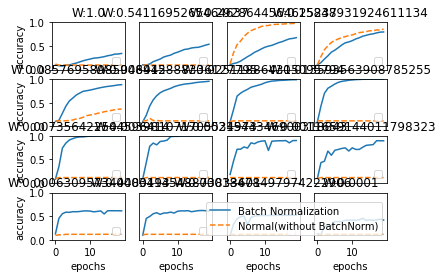

In [21]:
from ch06 import batch_norm_test

### 6.4 바른 학습을 위해

**오버피팅**은 주로 다음의 두 경우에 일어난다.

- 매개변수가 많고 표현력이 높은 모델

- 훈련 데이터가 작음

이 두 요건을 일부러 충족하여 오버피팅을 일으켜보자

In [22]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [23]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

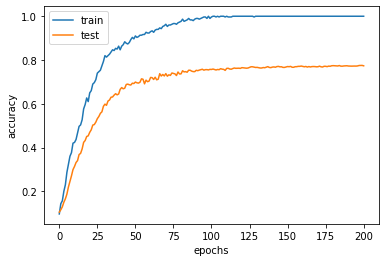

In [24]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

- **가중치 감소** : 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅 억제

 (오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문)

 예를 들어, 가중치의 제곱 노름을 손실함수에 더한다.

 $L(W) + \frac{1}{2}\lambda W^2$

 - L2 노름을 더해주면, 해당 손실값이 높아지고, 학습은 손실값을 줄이는 방향으로 진행되므로, 가중치가 클수록 가중치에 대한 패널티를 줄수 있는 것이다.

 - $\lambda$가 크다면 모델이 훈련 데이터에 대해서 적합한 매개 변수를 찾는 것보다 규제를 위해 추가된 항들을 작게 유지하는 것을 우선한다는 의미가 됨.

 ---

- **드롭아웃** : 뉴런을 임의로 삭제하면서 학습하는 방법

 시험 때는 모든 뉴런에 신호를 전달 ( 단, 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력 )

In [25]:
# 드롭아웃 구현

class Dropout(object):
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:   # 훈련 시에 self.mask에 삭제할 뉴런을 False로 표시
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio   # *의미: 튜플 형태로 받는다
            # 배열을 무작위로 생성, 그 값이 dropout_ratio보다 큰 것만 True로 설정
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)  # 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력
        
    def backward(self, dout):
        return dout * self.mask   # 순전파에서 False가 된 것들은 역전파에도 신호 차단

train loss:2.320356039157845
=== epoch:1, train acc:0.08333333333333333, test acc:0.1001 ===
train loss:2.3003586915873573
train loss:2.3162619400162354
train loss:2.3122445870996233
=== epoch:2, train acc:0.08666666666666667, test acc:0.1008 ===
train loss:2.2915012720956387
train loss:2.306775905631584
train loss:2.3055586619663386
=== epoch:3, train acc:0.09, test acc:0.1013 ===
train loss:2.2864934793031826
train loss:2.3016314660750483
train loss:2.302953086538835
=== epoch:4, train acc:0.09, test acc:0.1036 ===
train loss:2.305924076061048
train loss:2.2875047554546875
train loss:2.289106086141403
=== epoch:5, train acc:0.09666666666666666, test acc:0.1045 ===
train loss:2.2796016459112782
train loss:2.3070144099237373
train loss:2.2806228570652185
=== epoch:6, train acc:0.10333333333333333, test acc:0.1066 ===
train loss:2.2825870174403597
train loss:2.3135922986761592
train loss:2.2863647917854393
=== epoch:7, train acc:0.10333333333333333, test acc:0.107 ===
train loss:2.30402

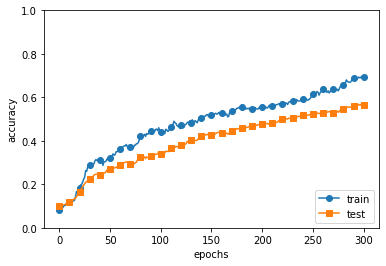

In [26]:
# MNIST 데이터셋으로 드롭아웃 효과 확인하기

from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer  # 신경망 학습을 대신 해주는 메서드

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었다 --> 오버피팅 억제!

머신러닝에서의 앙상블 학습과 유사하다 ( 드롭아웃이 학습 때 매번 다른 모델을 학습시키는 것으로 볼 수 있다 )

### 6.5 적절한 하이퍼파라미터 값 찾기

- 훈련 데이터 : 매개변수 학습

- 검증 데이터 : 하이퍼파라미터 성능 평가

- 시험 데이터 : 신경망의 범용 성능 평가

In [27]:
# 훈련 데이터에서 검증 데이터 분리하기

from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)  # 훈련 데이터 섞기

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

하이퍼파라미터 최적화 : 

1. 하이퍼파라미터 값의 범위 설정 (주로, 로그 스케일로 지정)

2. 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출

3. 2단계에서 샘플링한 하이퍼파라미터의 값을 사용하여 학습 후, 검증 데이터로 정확도 평가 (에폭은 작게 설정)

4. 2단계와 3단계를 특정 획수 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

범위가 어느 정도 좁아지면 그 범위에서 값을 하나 골라낸다.

In [28]:
# 무작위로 하이퍼파라미터 범위 설정
weight_decay = 10 ** np.random.uniform(-8,-4)  # random.uniform(a,b): a,b 사이의 부동소수점 난수 발생
lr = 10 ** np.random.uniform(-6,-2)

In [29]:
print(weight_decay, lr)

9.433033091554825e-05 0.0032230001950956325


다양한 하이퍼파라미터 값으로 학습을 반복하며 관찰해보자

val acc:0.15 | lr:5.525104423639638e-06, weight decay:7.623014758287353e-05
val acc:0.1 | lr:0.001140553360915775, weight decay:1.8959913973425324e-07
val acc:0.07 | lr:2.154505701584187e-06, weight decay:4.114670195896361e-06
val acc:0.02 | lr:2.730612475333678e-06, weight decay:5.169912413613183e-07
val acc:0.52 | lr:0.003966014273974248, weight decay:1.4773373871991915e-06
val acc:0.15 | lr:0.0010032064067764536, weight decay:3.687495084881093e-06
val acc:0.3 | lr:0.0011477184467091426, weight decay:4.4175956759289503e-07
val acc:0.18 | lr:2.73350231893843e-05, weight decay:9.348198158300759e-08
val acc:0.52 | lr:0.0036355021460603857, weight decay:3.7886659450071276e-06
val acc:0.06 | lr:2.0603094617824678e-06, weight decay:1.7043857601141448e-06
val acc:0.2 | lr:0.0003912288936202401, weight decay:3.133091175953559e-08
val acc:0.29 | lr:0.0009511973281128005, weight decay:9.882957095509787e-05
val acc:0.8 | lr:0.008150825385704438, weight decay:4.7009577916342314e-05
val acc:0.05 

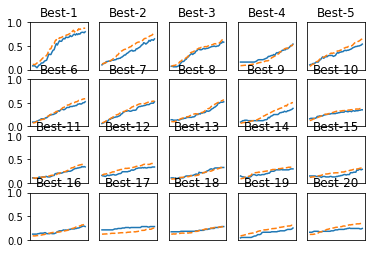

In [30]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

    Best-1(val acc:0.73) | lr:0.008507374603905195, weight decay:3.5803316361309514e-05

    Best-2(val acc:0.72) | lr:0.007215643739575296, weight decay:1.2035895837918405e-07

    Best-3(val acc:0.71) | lr:0.009188064115272945, weight decay:4.007853060571838e-05

    Best-4(val acc:0.55) | lr:0.005222172711613795, weight decay:9.153348131843417e-05

    Best-5(val acc:0.48) | lr:0.00346334550388214, weight decay:1.364321743823352e-05

가장 잘 학습이 된 모델의 하이퍼파라미터 값의 범위를 관찰하고 범위를 좁혀나간다 --> 작업 반복 --> 하이퍼파라미터 값 선택